# Reading the Data

First we read the Signal Data and produce a heatmap from the average of all lines. We do so, in order to get the feeling of what our data looks like.

In [1]:
# Importing the dataset
signal_data = read.table('signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt')
print(dim(signal_data))
print(as.matrix(signal_data[1:10,625]))

[1] 11298   625
      [,1]
 [1,]    0
 [2,]    0
 [3,]    0
 [4,]    0
 [5,]    0
 [6,]    0
 [7,]    0
 [8,]    0
 [9,]    0
[10,]    0


Then, we calculate the average of all observations.

In [2]:
mean_signal <- colMeans(signal_data)

Now draw the Heatmap



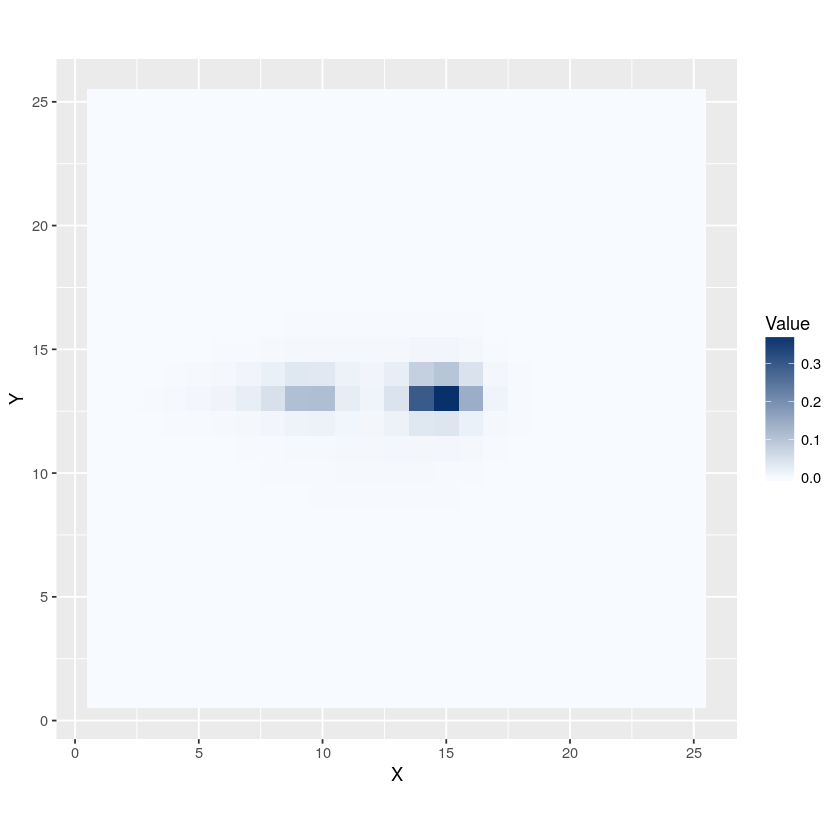

In [3]:
# Printing heatmap
dim(mean_signal) <- c(25,25)
library(ggplot2)  
library(RColorBrewer)  
library(reshape2)
mean_signal.melted <- melt(mean_signal)
colnames(mean_signal.melted) <- c("X", "Y","Value")
hm.palette <- colorRampPalette(c("#f7fbff", "#08306b"))
ggplot(mean_signal.melted, aes(x = X, y = Y, fill = Value)) +  
  geom_tile() +
  coord_equal() +
  scale_fill_gradientn(colours = hm.palette(100))

We then add a last column, with the value of `1`. This last column classify this data as signal data. After creating the full dataset we will rename this column to _class_.

In [4]:
signal_data[,626] <- 1
print(as.matrix(signal_data[1:10,626]))

      [,1]
 [1,]    1
 [2,]    1
 [3,]    1
 [4,]    1
 [5,]    1
 [6,]    1
 [7,]    1
 [8,]    1
 [9,]    1
[10,]    1


After preprocessing the _signal_ data, we will perform the same steps with the _background_ data.

In [5]:
background_data = read.table('background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt')
print(dim(background_data))

[1] 11298   625


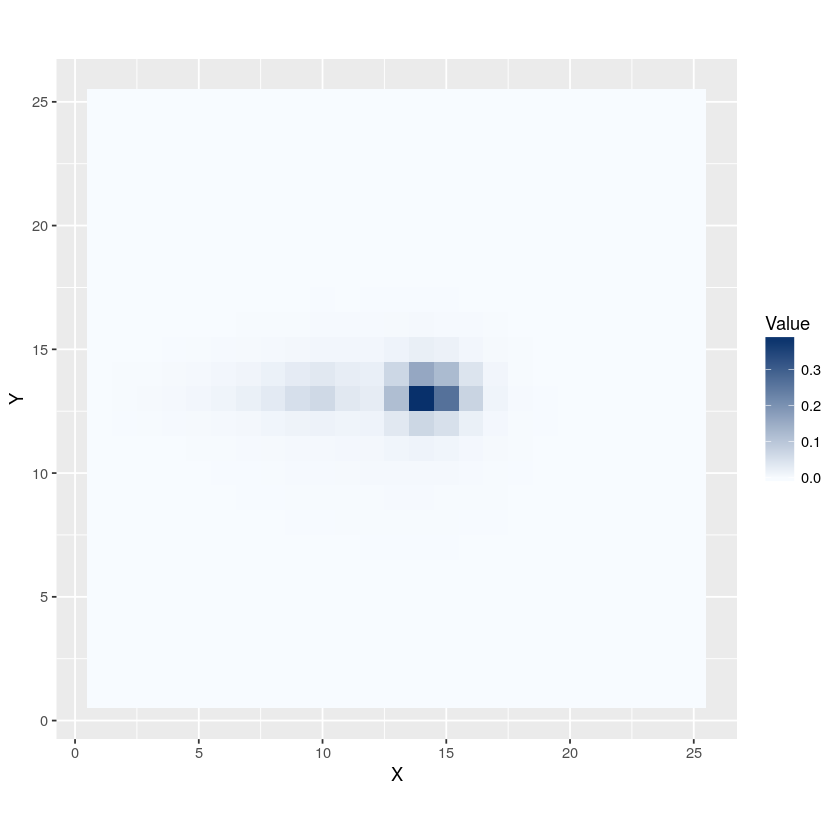

In [6]:
mean_background <- colMeans(background_data)
dim(mean_background) <-c(25, 25)
mean_background.melted <- melt(mean_background)
colnames(mean_background.melted) <- c("X", "Y","Value")
ggplot(mean_background.melted, aes(x = X, y = Y, fill = Value)) +  
  geom_tile() +
  coord_equal() +
  scale_fill_gradientn(colours = hm.palette(100))

We modify this data, to point out that this is the background data, by setting the last column to 0.

In [7]:
background_data[,626] <- 0
print(as.matrix(background_data[1:10,626]))

      [,1]
 [1,]    0
 [2,]    0
 [3,]    0
 [4,]    0
 [5,]    0
 [6,]    0
 [7,]    0
 [8,]    0
 [9,]    0
[10,]    0


Now we concatenate the data and shuffle it in order to randomize its columns.

In [8]:
full_data <- rbind(signal_data,background_data)
set.seed(123) # reproduce results
full_data <- full_data[sample(nrow(full_data)),] 
print(as.matrix(full_data[1:10,626]))

      [,1]
 [1,]    1
 [2,]    0
 [3,]    1
 [4,]    0
 [5,]    0
 [6,]    1
 [7,]    0
 [8,]    0
 [9,]    0
[10,]    1


# Defining and Training the model

Split the full dataset into test and train data in a 70-30% rate.


In [9]:
library(caTools)
set.seed(123)
split = sample.split(full_data[[626]], SplitRatio = 0.7)
training_set = subset(full_data, split == TRUE)
test_set = subset(full_data, split == FALSE)
print(dim(training_set))
print(dim(test_set))

[1] 15818   626
[1] 6778  626


Removing zero variance columns

In [10]:
test_set <- test_set[,apply(training_set, 2, var, na.rm=TRUE) != 0]
training_set <-training_set[,apply(training_set, 2, var, na.rm=TRUE) != 0]

Applying Principal Component Analysis (PCA)

In [11]:
library(caret)
library(e1071)
pcaElem = 60
pca = preProcess(x = training_set[-540], method = 'pca', pcaComp = pcaElem)  
training_set = predict(pca, training_set)
training_set = training_set[c(2:(pcaElem+1),1)]
test_set = predict(pca, test_set)
test_set = test_set[c(2:(pcaElem+1),1)]

Loading required package: lattice


Fitting Logistic Regression to the Training set

In [12]:
classifier <- glm(formula = V626 ~ .,
                family = binomial,
                data = training_set)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Predicting the Test set results

In [13]:
prob_pred <- predict(classifier, type = 'response', newdata = test_set[-(pcaElem+1)])
y_pred <- ifelse(prob_pred > 0.5, 1, 0)

# Computing accuracy

In [14]:
misClasificError <- mean((y_pred > 0.5) != test_set[(pcaElem+1)])
print(paste('Accuracy',1-misClasificError))

[1] "Accuracy 0.726467984656241"
